# Relax Data Science Challenge

Using two data tables containing information about users and user activity, the challenge is this:

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least one seven day  period,  identify  which  factors  predict  future  user adoption.

My strategy is this: I am considering this a classification problem. I need to create an 'adopted user' feature in one of the tables. This feature will be binary. It will have a 1 for if the user is adopted, meaning they are a user who has logged into the product on three separate days in at least one seven day period, and a 0 for if the user is not adopted. Every user falls into the adopted or not adopted category, so there should be a 1 or a 0 for every unique user. I will fit a random forest model to the data and extract feature importance to identify which factors predict user adoption.

### Pt. 1 Loading and Data Inspection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')
users_df = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')

In [3]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
engagement_df.shape

(207917, 3)

In [6]:
users_df.shape

(12000, 10)

In [7]:
engagement_df.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [8]:
users_df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

### Pt. 2 Data Cleaning

In [9]:
users_df.rename(columns = {'object_id': 'user_id'}, inplace = True)

In [10]:
# Just to keep things a little tidier, we're going to drop some columns that we're pretty sure are irrelevant for the task
users_df.drop(columns = ['name', 'email'], inplace = True)

In [11]:
# Change the last session creation time to something more human readable
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit = 's')

In [12]:
engagement_df.isna().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [13]:
users_df.isna().sum()

user_id                          0
creation_time                    0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [14]:
# Let's fill the invited_by_user_id column first. Since a user's id is present only when applicable, we can fill the missing
# values with 0.
users_df.invited_by_user_id.fillna(value = 0.0, inplace = True)

In [15]:
# User ids are integers
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].astype(int)

In [16]:
# Try to understand any patterns with users missing a last session creation time
# To that end, we make a new dataframe consisting of only those users with missing values for last session creation time
no_last_session = users_df.copy()[users_df.isna().any(axis=1)]

In [17]:
no_last_session.shape

(3177, 8)

In [18]:
no_last_session.head()

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
7,8,2013-07-31 05:34:02,PERSONAL_PROJECTS,NaT,1,1,74,0
8,9,2013-11-05 04:04:24,PERSONAL_PROJECTS,NaT,0,0,302,0
11,12,2014-04-17 23:48:38,ORG_INVITE,NaT,0,0,130,9270
14,15,2013-07-16 21:33:54,PERSONAL_PROJECTS,NaT,0,0,175,0
15,16,2013-02-11 10:09:50,PERSONAL_PROJECTS,NaT,0,0,211,0


In [19]:
# Signup creation source is by far the least, but all four sources have missing last session creation time values
# None signed up using Google's authentication
# And lastly, all these users were invited to use the product, rather than signed up themselves
no_last_session.groupby('creation_source').count().sort_values(by = 'user_id', ascending = False)

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_source,,,,,,,
PERSONAL_PROJECTS,1347,1347,0,1347,1347,1347,1347
ORG_INVITE,1066,1066,0,1066,1066,1066,1066
GUEST_INVITE,575,575,0,575,575,575,575
SIGNUP,189,189,0,189,189,189,189


In [20]:
# Most users with a missing value for last session creation time did not opt in to the mailing list
no_last_session.groupby('opted_in_to_mailing_list').count().sort_values(by = 'opted_in_to_mailing_list', ascending = False)

,user_id,creation_time,creation_source,last_session_creation_time,enabled_for_marketing_drip,org_id,invited_by_user_id
opted_in_to_mailing_list,,,,,,,
1,768,768,768,0,768,768,768
0,2409,2409,2409,0,2409,2409,2409


In [21]:
# Most users with a missing value for last session creation time have not had marketing drop enabled
no_last_session.groupby('enabled_for_marketing_drip').count().sort_values(by = 'enabled_for_marketing_drip', ascending = False)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,org_id,invited_by_user_id
enabled_for_marketing_drip,,,,,,,
1,451,451,451,0,451,451,451
0,2726,2726,2726,0,2726,2726,2726


In [22]:
# Build a feature of 1 for when invited_by_user_id is above zero and 0 otherwise
invited_by_user = []
for i in no_last_session['invited_by_user_id']:
    if i > 0:
        invited_by_user.append(1)
    else:
        invited_by_user.append(0)

no_last_session['invited_by_user_or_not'] = invited_by_user

# We want to see if, among the users with missing values for last_session_creation_time, there's a pattern with whether
# they were missing values for the invited_by_user_id column or not. It seems pretty half and half. Not informative
no_last_session.groupby('invited_by_user_or_not').count().sort_values(by = 'invited_by_user_or_not', ascending = False)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
invited_by_user_or_not,,,,,,,,
1,1641,1641,1641,0,1641,1641,1641,1641
0,1536,1536,1536,0,1536,1536,1536,1536


In [23]:
users_df[users_df['invited_by_user_id'] == 0].groupby('creation_source').count()

,user_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_source,,,,,,,
PERSONAL_PROJECTS,2111,2111,764,2111,2111,2111,2111
SIGNUP,2087,2087,1898,2087,2087,2087,2087
SIGNUP_GOOGLE_AUTH,1385,1385,1385,1385,1385,1385,1385


Oddly among the set of users who had missing values for 'invited_by_user_id' (which we interpreted as not being invited by another user), the PERSONAL_PROJECTS was the most frequent creation source. The PERSONAL_PROJECTS creation source is defined as a user who has been "invited  to  join  another  user's personal  workspace." Either a user can be invited by a entity that isn't another user (or an organization, as there is the ORG_INVITE category for that), or our interpretation of the missing values in the invited_by_user_id column was incorrect. I suspect the latter is the case, and the data is missing not because those users weren't invited by another user, but for another reason.

Not only have I become sidetracked from my current objective of addressing the missing values for the last_session_creation_time column, I've spent too much time on it. Under ordinary circumstances, such a large chunk of missing values cannot just be dropped. And furthermore, since eventually I will be training a random forest model on data from the users_df dataframe to predict adopted users, my intuition is that last_session_creation_time may be a useful feature. However, I've already exceeded the recommended time to work on this challenge, so I will be dropping the entire last_session_creation_time column and moving on.

In [24]:
users_df.drop(columns = 'last_session_creation_time', inplace = True)

In [25]:
# Change the time_stamp column to be datetime objects
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

### Pt. 3 Engineering our Dependent Variable

We want to be make an "adopted" column with 1's for users who have logged in three or more times in a consecutive seven day period and 0 if they haven't.

In [26]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


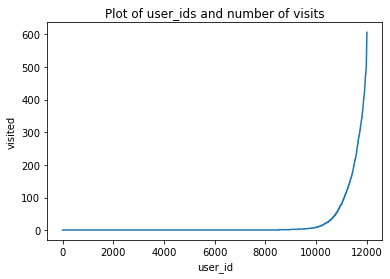

In [27]:
# Just to keep ourselves grounded about what to expect, most users logged in less than 100 times
sns.lineplot(data = engagement_df.groupby('user_id').count().sort_values(by = 'visited'), 
            x = engagement_df.groupby('user_id').count().index, y = 'visited')
plt.title('Plot of user_ids and number of visits')
plt.show()

In [28]:
engagement_df.groupby('user_id').count().describe()

,time_stamp,visited
count,8823.000000,8823.000000
mean,23.565341,23.565341
std,73.988152,73.988152
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,3.000000,3.000000
max,606.000000,606.000000


In [29]:
# It seems almost 75% of users have logged in fewer than 3 times. This means that almost 75% of users cannot possibly
# be considered adopted users, and the actual number of adopted users will most likely be less than 25% of the total population.
len(engagement_df.groupby('user_id').count()[engagement_df.groupby('user_id').count()['visited'] < 3])\
/ len(engagement_df.groupby('user_id').count())

0.7452113793494276

In [30]:
# A separate dataframe for experimenting
df = engagement_df.copy()

In [31]:
# Set the index to be the time_stamps, sort the time_stamps
df.set_index('time_stamp', inplace = True)
df.sort_index(inplace = True)
df.head()

,user_id,visited
time_stamp,,
2012-05-31 08:20:06,10012,1
2012-05-31 15:47:36,3428,1
2012-05-31 17:19:37,9899,1
2012-05-31 21:58:33,1693,1
2012-06-01 00:17:30,6102,1


In [32]:
# The .rolling() method allows us to perform rolling window calculations. We group by user id, then form rolling 7 day windows 
# where we count the number of visits of each id in that 7 day window
roller = df.groupby('user_id').rolling('7d').count()
roller.head()

visited
user_id time_stamp                  
1       2014-04-22 03:53:30      1.0
2       2013-11-15 03:45:04      1.0
        2013-11-29 03:45:04      1.0
        2013-12-09 03:45:04      1.0
        2013-12-25 03:45:04      1.0

In [50]:
# Filter for just those users who have logged in at least three times in a consecutive one week period (adopted)
adopted_df = roller[roller >= 3].dropna()
adopted_df

visited
user_id time_stamp                  
2       2014-02-09 03:45:04      3.0
        2014-02-13 03:45:04      3.0
10      2013-02-19 22:08:03      3.0
        2013-03-02 22:08:03      3.0
        2013-03-05 22:08:03      3.0
...                              ...
11988   2014-05-23 11:04:47      6.0
        2014-05-24 11:04:47      6.0
        2014-05-26 11:04:47      5.0
        2014-05-27 11:04:47      5.0
        2014-06-01 11:04:47      3.0

[160522 rows x 1 columns]

In [64]:
duplicate_adoptees = []
for user in adopted_df.index:
    duplicate_adoptees.append(user[0])

duplicate_adoptees = pd.Series(duplicate_adoptees)
unique_adoptees = duplicate_adoptees.unique()
unique_adoptees

array([    2,    10,    20, ..., 11969, 11975, 11988], dtype=int64)

At this point I have run up against a wall. As I am treating this like a timed interview take home challenge, I must admit that I am stuck and turn in what I have. I've already spent about triple the amount of suggested time to work on this. The snag is here: I believe I have collected an array of the adopted users, under the given definition for what constitutes an adopted user. What I need to do now is make a new column in the users_df dataframe with value of 1 for every user_id on that list, and 0 for every user_id not on that list. 

Once that adopted_status column is in place, I could run a random forest model with that as the y array, and the other columns as the X arrays. I could extract feature importances from the model, and this would give us a rough idea of what factors predict future user adoption.